# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682-fa19.github.io/assignments2019/assignment1/) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
from __future__ import print_function
import random
import numpy as np
from cs682.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs682/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs682/classifiers/softmax.py**. 


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs682/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs682.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.308895
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** The weights are pretty close to zero so the scores for each class will be close to zero as well. When we take the exponential, these become 1 and essentially the loss term becomes the -log of 1/(number of classes). Since there are 10 classes in this dataset, its -log(0.1).

In [14]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs682.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.296736 analytic: -2.296736, relative error: 1.919162e-08
numerical: -3.138822 analytic: -3.138822, relative error: 8.292281e-09
numerical: -4.385794 analytic: -4.385794, relative error: 1.122662e-08
numerical: -0.328705 analytic: -0.328705, relative error: 9.498133e-08
numerical: 0.203994 analytic: 0.203994, relative error: 2.583176e-07
numerical: -2.247890 analytic: -2.247890, relative error: 1.070537e-08
numerical: -0.548313 analytic: -0.548313, relative error: 5.162045e-08
numerical: -1.581504 analytic: -1.581505, relative error: 1.321802e-08
numerical: -0.206610 analytic: -0.206611, relative error: 2.457113e-07
numerical: -2.207915 analytic: -2.207915, relative error: 7.294415e-09
numerical: 2.001808 analytic: 2.001808, relative error: 2.225024e-08
numerical: -0.527061 analytic: -0.527061, relative error: 1.040863e-07
numerical: 1.288833 analytic: 1.288833, relative error: 8.660906e-09
numerical: 0.998188 analytic: 0.998188, relative error: 3.207232e-08
numerical: -0.

In [59]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs682.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.308895e+00 computed in 0.349140s
vectorized loss: 2.308895e+00 computed in 0.008240s
Loss difference: 0.000000
Gradient difference: 0.000000


In [61]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs682.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7, 1e-9, 3e-6, 4e-8]
regularization_strengths = [2.5e4, 5e4, 1e3]

softmax = Softmax()
for rate in learning_rates:
    for strength in regularization_strengths:
        print('lr = %e reg = %e' % (rate, strength))
        loss = softmax.train(X_train, y_train, learning_rate=rate, reg=strength, num_iters=1500, verbose=True)
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        training_accuracy, validation_accuracy = np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred)
        results[(rate, strength)] = (training_accuracy, validation_accuracy)
        
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_softmax = softmax
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr = 1.000000e-07 reg = 2.500000e+04
iteration 0 / 1500: loss 781.136078
iteration 100 / 1500: loss 286.478689
iteration 200 / 1500: loss 106.196882
iteration 300 / 1500: loss 40.217597
iteration 400 / 1500: loss 16.025875
iteration 500 / 1500: loss 7.232468
iteration 600 / 1500: loss 4.003797
iteration 700 / 1500: loss 2.747967
iteration 800 / 1500: loss 2.295947
iteration 900 / 1500: loss 2.181972
iteration 1000 / 1500: loss 2.145603
iteration 1100 / 1500: loss 2.111826
iteration 1200 / 1500: loss 2.129887
iteration 1300 / 1500: loss 2.082186
iteration 1400 / 1500: loss 2.163275
lr = 1.000000e-07 reg = 5.000000e+04
iteration 0 / 1500: loss 2.164597
iteration 100 / 1500: loss 2.110290
iteration 200 / 1500: loss 2.158329
iteration 300 / 1500: loss 2.128660
iteration 400 / 1500: loss 2.119830
iteration 500 / 1500: loss 2.134187
iteration 600 / 1500: loss 2.142399
iteration 700 / 1500: loss 2.236839
iteration 800 / 1500: loss 2.124527
iteration 900 / 1500: loss 2.102708
iteration 1000 / 

iteration 100 / 1500: loss 2.007135
iteration 200 / 1500: loss 2.037298
iteration 300 / 1500: loss 1.981162
iteration 400 / 1500: loss 1.933295
iteration 500 / 1500: loss 1.926812
iteration 600 / 1500: loss 2.006622
iteration 700 / 1500: loss 2.004399
iteration 800 / 1500: loss 1.824847
iteration 900 / 1500: loss 1.920589
iteration 1000 / 1500: loss 1.903265
iteration 1100 / 1500: loss 1.927944
iteration 1200 / 1500: loss 1.803908
iteration 1300 / 1500: loss 1.911375
iteration 1400 / 1500: loss 1.948992
lr 1.000000e-09 reg 1.000000e+03 train accuracy: 0.403082 val accuracy: 0.405000
lr 1.000000e-09 reg 2.500000e+04 train accuracy: 0.405082 val accuracy: 0.401000
lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.404939 val accuracy: 0.399000
lr 4.000000e-08 reg 1.000000e+03 train accuracy: 0.366694 val accuracy: 0.373000
lr 4.000000e-08 reg 2.500000e+04 train accuracy: 0.333857 val accuracy: 0.349000
lr 4.000000e-08 reg 5.000000e+04 train accuracy: 0.304510 val accuracy: 0.317000
lr 1.

In [62]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.370000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: True

*Your explanation*: Theoretically, we can add a datapoint that has a loss of exactly the previous average SVM loss, so that the new average loss will remain the same.

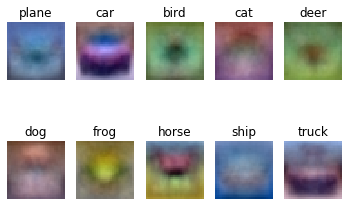

In [63]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])